In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback

In [8]:
#Load Data
bitcoin_data = pd.read_csv('bitcoin_price_non_string_full.csv', sep=';')
bitcoin_data = bitcoin_data[['Price']].values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_data = scaler.fit_transform(bitcoin_data)
bitcoin_data_df = pd.DataFrame(bitcoin_data, columns=['Price'])

print(bitcoin_data_df)

         Price
0     0.849164
1     0.886100
2     0.893721
3     0.860474
4     0.861401
...        ...
1230  0.039924
1231  0.043595
1232  0.048839
1233  0.044906
1234  0.059957

[1235 rows x 1 columns]


In [9]:
#Mengubah data menjadi pasangan input dan output untuk model
def prepare_data(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


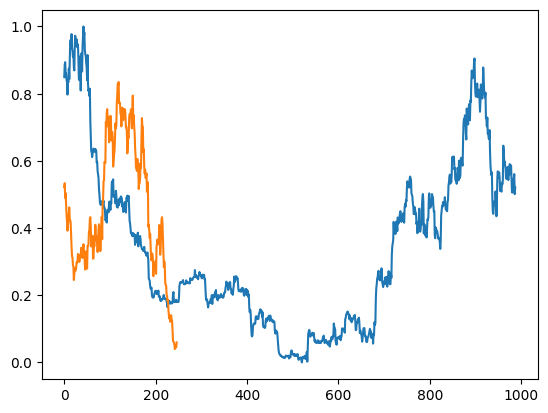

     variable     value
0       Train  0.849164
1       Train  0.886100
2       Train  0.893721
3       Train  0.860474
4       Train  0.861401
...       ...       ...
1230     Test  0.039924
1231     Test  0.043595
1232     Test  0.048839
1233     Test  0.044906
1234     Test  0.059957

[1235 rows x 2 columns]


In [10]:
#Pembagian Data
look_back = 10
train_size = int(len(bitcoin_data) * 0.8)
test_size = len(bitcoin_data) - train_size
train, test = bitcoin_data[0:train_size,:], bitcoin_data[train_size:len(bitcoin_data),:]
trainX, trainY = prepare_data(train, look_back)
testX, testY = prepare_data(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

plt.plot(train)
plt.plot(test)
plt.show()

table_data = {'train': train.flatten(), 'test': test.flatten()}

table = pd.DataFrame({'variable': ['Train'] * len(train) + ['Test'] * len(test), 'value': np.concatenate((train.flatten(), test.flatten()))})

print(table)

In [11]:
#Pembuatan Model
class MAPECallback(Callback):
    def __init__(self, validation_data):
        super(MAPECallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
        print(f' - val_mape: {mape:.2f}%')

# Inisialisasi model
model = Sequential()
model.add(LSTM(units=100, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Callback untuk MAPE
mape_callback = MAPECallback(validation_data=(testX, testY))

# Fit model
history = model.fit(trainX, trainY, epochs=100, batch_size=64,
                    validation_data=(testX, testY),
                    callbacks=[early_stopping, mape_callback], verbose=2)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
 - val_mape: 101.47%
16/16 - 4s - 261ms/step - loss: 0.0588 - val_loss: 0.0152
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
 - val_mape: 77.46%
16/16 - 0s - 24ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_mape: 83.67%
16/16 - 0s - 25ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
 - val_mape: 85.75%
16/16 - 0s - 24ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_mape: 84.68%
16/16 - 0s - 24ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
 - val_mape: 84.23%
16/16 - 0s - 23ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
 - val_mape: 84.73%
16/16 - 0s - 23ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
 - val_mape: 82.95%
16/16 - 1s - 42ms/step - loss: 0.0025 -

In [12]:
#Pickle

import pickle

with open('lstm.pickle', 'wb') as r:
    pickle.dump(history, r)

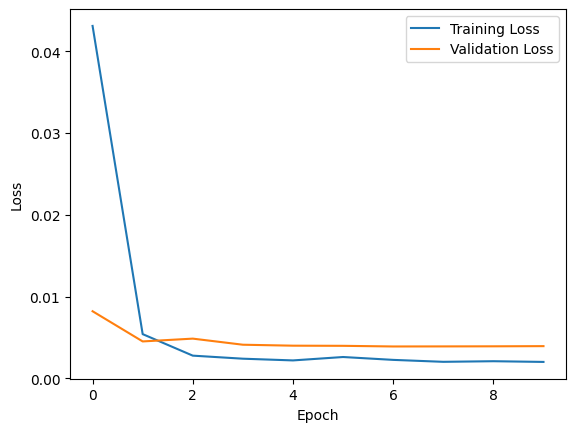

   Epoch  Training Loss  Validation Loss       MAPE
0      0       0.043084         0.008215  80.933017
1      1       0.005419         0.004526  16.476221
2      2       0.002789         0.004868  74.578302
3      3       0.002416         0.004123  70.692207
4      4       0.002205         0.004006  81.695969
5      5       0.002621         0.003989  52.170519
6      6       0.002271         0.003909  72.148555
7      7       0.002034         0.003918  92.632202
8      8       0.002108         0.003929  86.402641
9      9       0.002021         0.003950  95.431586


In [109]:
#Evaluasi Model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Hitung MAPE untuk setiap epoch
val_mape = []
for i in range(len(history.history['val_loss'])):
    val_mape.append(100 * abs((history.history['val_loss'][i] - history.history['loss'][i]) / history.history['loss'][i]))

table_data = {'Epoch': range(len(history.history['loss'])),
              'Training Loss': history.history['loss'],
              'Validation Loss': history.history['val_loss'],
              'MAPE': val_mape}

table = pd.DataFrame(table_data)

print(table)

In [110]:
#Evaluasi Hasil
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
train_score = np.sqrt(np.mean(np.square(train_predict - trainY)))
test_score = np.sqrt(np.mean(np.square(test_predict - testY)))

print("RMSE Train:", train_score)
print("RMSE Test:", test_score)

#Percobaan Prediksi 2 hari Kedepan
future_days = 5
future_input = trainX[-future_days:]
future_output = model.predict(future_input)
future_output = scaler.inverse_transform(future_output)

# Tampilkan hasil prediksi
print("Prediksi 2 Hari Ke Depan:")
print(future_output)

for i in range(len(future_output)):
    if future_output[i] > future_output[i-1]:
        print(f"Hari {i+1}: Naik")
    elif future_output[i] < future_output[i-1]:
        print(f"Hari {i+1}: Turun")
    else:
        print(f"Hari {i+1}: Stabil")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
RMSE Train: 194423.73267813647
RMSE Test: 158318.73004012203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediksi 2 Hari Ke Depan:
[[463697.1 ]
 [460824.72]
 [459454.97]
 [459070.66]
 [456295.03]]
Hari 1: Naik
Hari 2: Turun
Hari 3: Turun
Hari 4: Turun
Hari 5: Turun


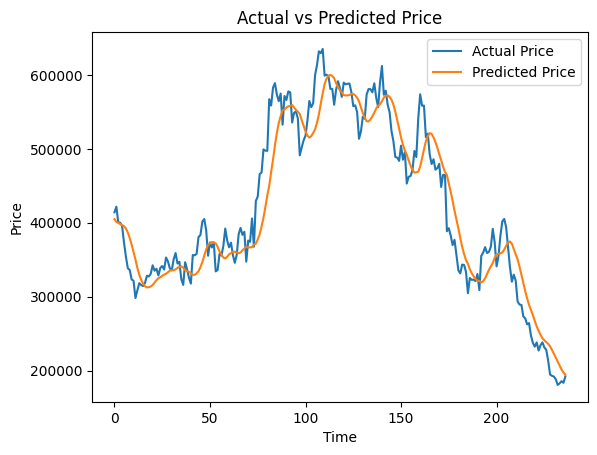

     Time   Actual Price  Predicted Price
0       0  414090.009869    404891.906250
1       1  421690.013531    401129.218750
2       2  400410.016917    399677.343750
3       3  400040.012746    398338.625000
4       4  395630.003577    396774.343750
..    ...            ...              ...
232   232  180499.993199    211828.046875
233   233  182600.008119    206447.562500
234   234  185600.005078    201456.218750
235   235  183350.007359    197392.796875
236   236  191959.995221    194195.078125

[237 rows x 3 columns]


In [111]:
#Visualisasi Hasil
plt.plot(testY.flatten(), label='Actual Price')
plt.plot(test_predict.flatten(), label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.show()

table_data = {'Time': range(len(testY.flatten())),
              'Actual Price': testY.flatten(),
              'Predicted Price': test_predict.flatten()}

table = pd.DataFrame(table_data)

print(table)

NameError: name 'history' is not defined